In [3]:
!uv sync --quiet
%env TORCH_LOGS=recompiles

import torch
from torch import nn

import src.models.trainer

torch.set_float32_matmul_precision('high')

env: TORCH_LOGS=recompiles


In [4]:
from pathlib import Path
import os

if not Path("./src/kernels").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/kernels").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/kernels").is_dir()

In [5]:
from src import kernels, load_data

In [6]:
import importlib

# from src.kernels import quadratic as quad_kernels
import src.load_data

# importlib.reload(src.models.simple_lenet)
# importlib.reload(src.load_data)
from src.models import simple_lenet
from src import load_data
# kernels = importlib.reload(kernels)
# convolutions = importlib.reload(convolutions)

In [7]:
k_mnist = load_data.k_mnist()
test_inp = k_mnist.x_train[:1024].cuda()

k_mnist

Dataset(x_train=torch.Size([60000, 1, 28, 28]), x_test=torch.Size([10000, 1, 28, 28]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [14]:
test_compile_mode = "default"
test_disable = True
test_model_std = torch.compile(simple_lenet.LeNet(img_channels=1, num_classes=10, pool_fn="standard-3").to('cuda'),
                               mode=test_compile_mode, disable=test_disable)
test_model_iso = torch.compile(simple_lenet.LeNet(img_channels=1, num_classes=10, pool_fn="iso-3").to('cuda'),
                               mode=test_compile_mode, disable=test_disable)
test_model_aniso = torch.compile(simple_lenet.LeNet(img_channels=1, num_classes=10, pool_fn="aniso-3").to('cuda'),
                                 mode=test_compile_mode, disable=test_disable)


def run_one(f):
    f(test_inp)
    torch.cuda.synchronize()


print("A")
run_one(test_model_std)
print("B")
run_one(test_model_iso)
print("C")
run_one(test_model_aniso)

print("Std")
%timeit run_one(test_model_std)
print("Iso")
%timeit run_one(test_model_iso)
print("Aniso")
%timeit run_one(test_model_aniso)

A
B
C
Std
311 μs ± 170 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Iso
404 μs ± 195 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Aniso
398 μs ± 735 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
# torch._dynamo.reset()
# with torch.autograd.detect_anomaly():
print(simple_lenet.LeNet.fit_many(k_mnist, batch_size=1024, torch_compile_mode="default", count=3, epochs=30,
                                  lr=0.004,
                                  progress_bar=False, pool_fn="standard-7", debug=False).scores)

shape: (3, 7)
┌──────────┬──────────┬──────────┬──────────┬─────────────┬───────────────┬──────────┐
│ acc      ┆ min_f1   ┆ max_f1   ┆ macro_f1 ┆ train_times ┆ compile_times ┆ times    │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---         ┆ ---           ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64         ┆ f64           ┆ f64      │
╞══════════╪══════════╪══════════╪══════════╪═════════════╪═══════════════╪══════════╡
│ 0.93457  ┆ 0.909091 ┆ 0.951193 ┆ 0.934396 ┆ 2.183828    ┆ 0.112041      ┆ 2.295869 │
│ 0.919379 ┆ 0.892662 ┆ 0.952279 ┆ 0.919278 ┆ 2.176775    ┆ 0.001004      ┆ 2.177779 │
│ 0.917643 ┆ 0.888764 ┆ 0.936654 ┆ 0.917453 ┆ 2.177672    ┆ 0.000961      ┆ 2.178633 │
└──────────┴──────────┴──────────┴──────────┴─────────────┴───────────────┴──────────┘


In [7]:
from pytorch_semifield_conv import cuda_select
from pytorch_semifield_conv.utils import ConvMeta

cuda_select.SelectSemifield.compile.__wrapped__.cache_info()

CacheInfo(hits=8, misses=2, maxsize=128, currsize=2)

In [13]:
ex_k = torch.zeros((3, 1, 3, 3)).cuda()
ex_k[:, :, :, 0] = -float("inf")
ex_k[:, :, :, 2] = -0.2
ex_img = test_inp.repeat((1, 3, 1, 1)).cuda()
ex_meta = ConvMeta.infer(ex_img, ex_k, stride=2, padding=1, groups=3)
d = cuda_select.SelectSemifield.tropical_max().compile(ex_meta)
print(id(d))
d

124105429861536


<CustomOpDef(ptex_jit::op_forwards_select__tropical_max_meta_3_28_28_1_3_1_3_3_3_14_14_2_1_1_3_0_1_3fdb10e53e154afcaf96ca710ad92d0d)>

In [14]:
torch.library.opcheck(d, (ex_img, ex_k))

{'test_schema': 'SUCCESS',
 'test_autograd_registration': 'SUCCESS',
 'test_faketensor': 'SUCCESS',
 'test_aot_dispatch_dynamic': 'SUCCESS'}

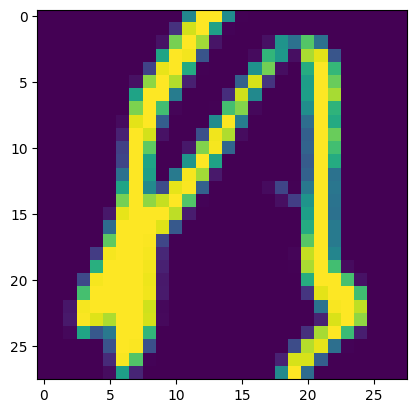

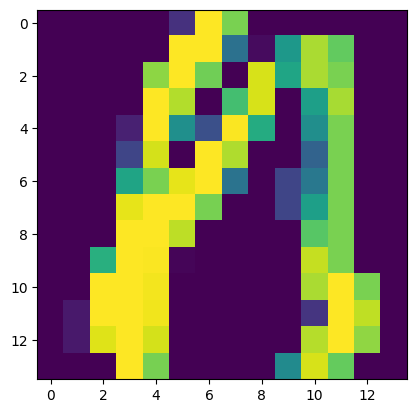

In [15]:
import matplotlib.pyplot as plt

res = d(ex_img, ex_k)[0].numpy(force=True)
plt.imshow(ex_img[0, 0].numpy(force=True))
plt.show()
plt.imshow(res[0, 0])

torch.Size([1024, 3, 28, 28])


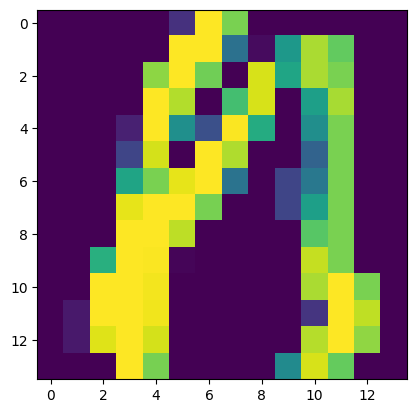

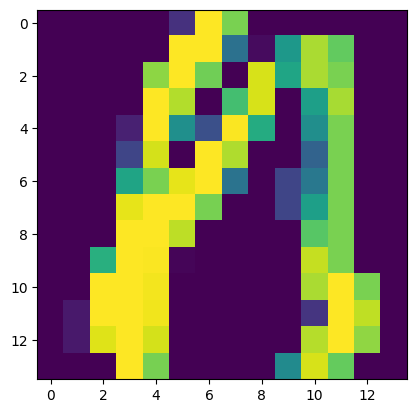

In [16]:
d_comp = torch.compile(d, mode="default")
print(ex_img.shape)
res = d_comp(ex_img, ex_k)[0].numpy(force=True)
plt.imshow(res[0, 0])
plt.show()
res = d_comp(ex_img, ex_k)[0].numpy(force=True)
plt.imshow(res[0, 0])

None
torch.Size([1024, 3, 28, 28])
A
B
[1.0000000e+01 9.9999999e-09 1.0000000e+01 9.9999999e-09 1.0000000e+01
 9.9999999e-09 1.0000000e+01 9.9999999e-09 1.0000000e+01 9.9999999e-09
 9.9999999e-09 4.6374507e-06 1.0000010e+01 1.0000010e+01 4.8727447e-06
 4.9215689e-08 1.0000000e+01 9.9999999e-09 1.0000000e+01 9.9999999e-09]


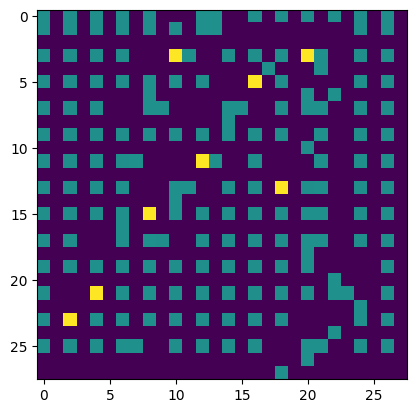

In [39]:
ex_img_g = ex_img.clone().requires_grad_(True).cuda()
ex_kern_g = ex_k.clone().requires_grad_(True).cuda()
print(ex_img_g.shape)
res = d(ex_img_g, ex_kern_g)[0]
print("A")
res.sum().backward()
print("B")
plt.imshow(ex_img_g.grad[0, 0].numpy(force=True))
print(ex_img_g.grad[0, 0].numpy(force=True).flat[:20])

In [30]:
from typing import NamedTuple


class A(NamedTuple):
    foo: int
    bar: str

    def __hash__(self):
        return hash(self.bar)

    def __eq__(self, other):
        return self.bar == other.bar


d = {}
d[A(1, "ree")] = 3
print(d)
d[A(2, "ree")] = 5
print(d)
d[A(2, "roo")] = 5
print(d)

{A(foo=1, bar='ree'): 3}
{A(foo=1, bar='ree'): 5}
{A(foo=1, bar='ree'): 5, A(foo=2, bar='roo'): 5}


In [20]:
torch.manual_seed(0)
torch._dynamo.reset()
m = simple_lenet.LeNet(img_channels=1, num_classes=10, pool_fn="aniso-3").to('cuda')
print(m(test_inp).numpy(force=True).flat[:20])
m.compile(mode='default', disable=False)
print(m(test_inp).numpy(force=True).flat[:20])
print(m(test_inp).numpy(force=True).flat[:20])
print(m(test_inp).numpy(force=True).flat[:20])

[ 0.00412754  0.00508913  0.0272331  -0.05368788 -0.00182536 -0.01768386
 -0.00480335 -0.03042536 -0.06981151  0.02945597  0.01315594  0.04164931
  0.05988334 -0.05391221  0.00048202 -0.05293098  0.00986339 -0.04104674
 -0.04843831 -0.00269065]
[ 0.00412754  0.00508913  0.0272331  -0.05368788 -0.00182536 -0.01768386
 -0.00480335 -0.03042536 -0.06981151  0.02945597  0.01315594  0.04164931
  0.05988334 -0.05391221  0.00048202 -0.05293098  0.00986339 -0.04104674
 -0.04843831 -0.00269065]
[ 0.00412754  0.00508913  0.0272331  -0.05368788 -0.00182536 -0.01768386
 -0.00480335 -0.03042536 -0.06981151  0.02945597  0.01315594  0.04164931
  0.05988334 -0.05391221  0.00048202 -0.05293098  0.00986339 -0.04104674
 -0.04843831 -0.00269065]
[ 0.00412754  0.00508913  0.0272331  -0.05368788 -0.00182536 -0.01768386
 -0.00480335 -0.03042536 -0.06981151  0.02945597  0.01315594  0.04164931
  0.05988334 -0.05391221  0.00048202 -0.05293098  0.00986339 -0.04104674
 -0.04843831 -0.00269065]


In [9]:
test_compile_mode = "max-autotune"
test_k_i = torch.compile(kernels.QuadraticKernelIso2D(1, 50, 3).cuda(), mode=test_compile_mode, disable=True)
test_k_c = torch.compile(kernels.QuadraticKernelCholesky2D(1, 50, 3).cuda(), mode=test_compile_mode)
test_k_s = torch.compile(kernels.QuadraticKernelSpectral2D(1, 50, 3).cuda(), mode=test_compile_mode)


def run_one(f):
    torch.compiler.cudagraph_mark_step_begin()
    f()
    torch.cuda.synchronize()


run_one(test_k_i)
run_one(test_k_c)
run_one(test_k_s)




%timeit run_one(test_k_i)
%timeit run_one(test_k_c)
%timeit run_one(test_k_s)

27.7 μs ± 58.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
42.3 μs ± 68 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
42.7 μs ± 57.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
torch.manual_seed(0)
kernels.QuadraticKernelCholesky2D(1, 50, 3).cuda()().numpy(force=True).flat[:10]

array([-0.12564707, -0.2249025 , -0.6018327 , -0.1388374 , -0.        ,
       -0.1388374 , -0.6018327 , -0.2249025 , -0.12564707, -0.10085675],
      dtype=float32)

In [19]:
torch.manual_seed(0)
test_k = torch.compile(kernels.QuadraticKernelCholesky2D(1, 50, 3).cuda(), mode="max-autotune")
print(test_k().numpy(force=True).flat[:10])
print(test_k().numpy(force=True).flat[:10])
print(test_k().numpy(force=True).flat[:10])

[-0.12564707 -0.2249025  -0.6018327  -0.1388374  -0.         -0.1388374
 -0.6018327  -0.2249025  -0.12564707 -0.10085675]
[-0.12564707 -0.2249025  -0.6018327  -0.1388374  -0.         -0.1388374
 -0.6018327  -0.2249025  -0.12564707 -0.10085675]
[-0.12564707 -0.2249025  -0.6018327  -0.1388374  -0.         -0.1388374
 -0.6018327  -0.2249025  -0.12564707 -0.10085675]


In [47]:
# %timeit test_model(test_run_pinned.cuda())
%timeit test_model(test_run_cuda)

663 μs ± 43.7 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


941 μs ± 132 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

671 μs ± 76.2 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

In [14]:
%timeit kmodel(k_mnist.x_train[:256])
%timeit kmodel(test_run_pinned)

1.14 ms ± 550 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.04 ms ± 179 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
%time kmodel.fit(k_mnist.x_train, k_mnist.y_train, batch_size=256, verbose=False)

CPU times: user 1.34 s, sys: 20.7 ms, total: 1.36 s
Wall time: 943 ms


In [49]:
xtrp = torch.as_tensor(k_mnist.x_train, device='cuda')
ytrp = torch.as_tensor(k_mnist.y_train, device='cuda')

In [60]:
%time hist = kmodel.fit(xtrp, ytrp, verbose=False, batch_size=256, epochs=5)

CPU times: user 5.54 s, sys: 109 ms, total: 5.65 s
Wall time: 4.19 s


In [59]:
def minitrain(epochs: int = 5):
    o = torch.optim.Adam(test_model.parameters())
    for _ in range(epochs):
        for xb, yb in k_mnist.train_loader(batch_size=256):
            o.zero_grad()
            res = test_model(xb.cuda())
            nn.functional.cross_entropy(res, yb.cuda()).backward()
            o.step()

%time minitrain()

CPU times: user 2min 15s, sys: 40.5 ms, total: 2min 15s
Wall time: 5.91 s


In [107]:

import src.kernels

importlib.reload(src.kernels.utils)
importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)

<module 'src.kernels' from '/home/peter/Thesis/src/kernels/__init__.py'>

In [120]:

from src.kernels.learned_pos_def import LearnedSpectral2D, LearnedCholesky2D
from src.kernels import QuadraticKernelCholesky2D, QuadraticKernelSpectral2D

k1 = LearnedCholesky2D(50, 60, init="normal")
k2 = LearnedSpectral2D(50, 60, init="normal")
print(k1, k2)
q1_3 = QuadraticKernelCholesky2D(50, 60, 3, init="normal")
q1_5 = QuadraticKernelCholesky2D(50, 60, 5, init="normal")
q1_10 = QuadraticKernelCholesky2D(50, 60, 10, init="normal")
q2_3 = QuadraticKernelSpectral2D(50, 60, 3, init="normal")
q2_5 = QuadraticKernelSpectral2D(50, 60, 5, init="normal")
q2_10 = QuadraticKernelSpectral2D(50, 60, 10, init="normal")
print(q1_3, q2_3, q1_5, q2_5)

LearnedCholesky2D(50, 60) LearnedSpectral2D(50, 60)
QuadraticKernelCholesky2D(
  50, 60, kernel_size=3
  (covs): LearnedCholesky2D(50, 60)
) QuadraticKernelSpectral2D(
  50, 60, kernel_size=3
  (covs): LearnedSpectral2D(50, 60)
) QuadraticKernelCholesky2D(
  50, 60, kernel_size=5
  (covs): LearnedCholesky2D(50, 60)
) QuadraticKernelSpectral2D(
  50, 60, kernel_size=5
  (covs): LearnedSpectral2D(50, 60)
)


In [109]:
print(k1.cholesky().shape)
print(k2.inverse_cov().shape)

torch.Size([60, 50, 2, 2])
torch.Size([60, 50, 2, 2])


In [110]:
print(q1_3().shape)
print(q2_3().shape)
print(q1_5().shape)
print(q2_5().shape)

torch.Size([60, 50, 3, 3])
torch.Size([60, 50, 3, 3])
torch.Size([60, 50, 5, 5])
torch.Size([60, 50, 5, 5])


In [121]:
q1_3.compile(fullgraph=True)
q2_3.compile(fullgraph=True)
q1_5.compile(fullgraph=True)
q2_5.compile(fullgraph=True)
q1_10.compile(fullgraph=True)
q2_10.compile(fullgraph=True)
print(q1_3().shape)
print(q2_3().shape)
print(q1_5().shape)
print(q2_5().shape)
print(q1_10().shape)
print(q2_10().shape)

torch.Size([60, 50, 3, 3])
torch.Size([60, 50, 3, 3])
torch.Size([60, 50, 5, 5])
torch.Size([60, 50, 5, 5])
torch.Size([60, 50, 10, 10])
torch.Size([60, 50, 10, 10])


/home/peter/Thesis/.venv/lib/python3.12/site-packages/torch/_inductor/lowering.py:1720: FutureWarning: `torch._prims_common.check` is deprecated and will be removed in the future. Please use `torch._check*` functions instead.
  check(


In [122]:
print(q1_3().shape)
print(q2_3().shape)
print(q1_5().shape)
print(q2_5().shape)
print(q1_10().shape)
print(q2_10().shape)

torch.Size([60, 50, 3, 3])
torch.Size([60, 50, 3, 3])
torch.Size([60, 50, 5, 5])
torch.Size([60, 50, 5, 5])
torch.Size([60, 50, 10, 10])
torch.Size([60, 50, 10, 10])


In [123]:
q1_3.cpu(), q2_3.cpu(), q1_5.cpu(), q2_5.cpu(), q1_10.cpu(), q2_10.cpu()
%timeit q1_3()
%timeit q2_3()
%timeit q1_5()
%timeit q2_5()
%timeit q1_10()
%timeit q2_10()

826 μs ± 2.56 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
117 μs ± 280 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
607 μs ± 350 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
175 μs ± 256 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.05 ms ± 315 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
168 μs ± 240 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [126]:
q1_3.cuda(), q2_3.cuda(), q1_5.cuda(), q2_5.cuda(), q1_10.cuda(), q2_10.cuda()
%timeit q1_3()
%timeit q2_3()
%timeit q1_5()
%timeit q2_5()
%timeit q1_10()
%timeit q2_10()

70.1 μs ± 64.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
74.8 μs ± 168 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
70.3 μs ± 71.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
74.9 μs ± 143 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
69.6 μs ± 75.9 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
75.5 μs ± 71.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [128]:
q2_5.state_dict()

OrderedDict([('pos_grid',
              tensor([[-2., -2.],
                      [-2., -1.],
                      [-2.,  0.],
                      [-2.,  1.],
                      [-2.,  2.],
                      [-1., -2.],
                      [-1., -1.],
                      [-1.,  0.],
                      [-1.,  1.],
                      [-1.,  2.],
                      [ 0., -2.],
                      [ 0., -1.],
                      [ 0.,  0.],
                      [ 0.,  1.],
                      [ 0.,  2.],
                      [ 1., -2.],
                      [ 1., -1.],
                      [ 1.,  0.],
                      [ 1.,  1.],
                      [ 1.,  2.],
                      [ 2., -2.],
                      [ 2., -1.],
                      [ 2.,  0.],
                      [ 2.,  1.],
                      [ 2.,  2.]], device='cuda:0')),
             ('covs.log_stds',
              tensor([[[ 0.5216,  1.1183],
                       [ 0.829